In [1]:
import torch
import os
import numpy as np
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

Text(0.5, 1.0, 'Fixed Image')

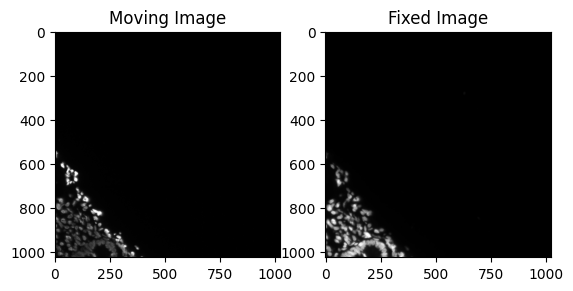

In [25]:
moving_img=np.load('/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/Figures_for_Paper/patch3_orig.npy')
fixed_img=np.load('/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/Figures_for_Paper/patch3_last.npy')

#Visualise moving and fixed images
plt.figure()
plt.subplot(1,2,1)
plt.imshow(moving_img,cmap='gray')
plt.title('Moving Image')
plt.subplot(1,2,2)
plt.imshow(fixed_img,cmap='gray')
plt.title('Fixed Image')


In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/Smoothness_1_epochs/epoch_15/epoch_15.pth'
model = vxm.networks.VxmDense.load(model_path, device)
model.to(device)
model.eval()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [27]:
def combine_displacement_fields(D1, D2):
    # Check if D1 and D2 are of the same shape
    assert D1.shape == D2.shape, "Displacement fields must have the same shape"
    
    # Initialize the combined displacement field with zeros
    D_combined = np.zeros_like(D1)
    
    # Get the shape of the displacement fields
    _, height, width = D1.shape
    
    # Prepare meshgrid for coordinate indices
    X, Y = np.meshgrid(np.arange(width), np.arange(height))
    
    # Apply D1 to get the intermediate displaced coordinates
    X_displaced = X + D1[0]
    Y_displaced = Y + D1[1]
    
    # Ensure the displaced coordinates are within bounds for interpolation
    X_displaced_clipped = np.clip(X_displaced, 0, width - 1)
    Y_displaced_clipped = np.clip(Y_displaced, 0, height - 1)
    
    # Interpolate D2 at the displaced coordinates
    D2_x_interpolated = map_coordinates(D2[0], [Y_displaced_clipped, X_displaced_clipped], order=1)
    D2_y_interpolated = map_coordinates(D2[1], [Y_displaced_clipped, X_displaced_clipped], order=1)
    
    # Combine D1 and interpolated D2
    D_combined[0] = D1[0] + D2_x_interpolated
    D_combined[1] = D1[1] + D2_y_interpolated
    
    return D_combined

In [28]:
moving_img=moving_img[np.newaxis,...,np.newaxis]
fixed_img=fixed_img[np.newaxis,...,np.newaxis]
moving_img = torch.from_numpy(moving_img).to(device).float().permute(0,3,1,2)
fixed_img = torch.from_numpy(fixed_img).to(device).float().permute(0,3,1,2)
pred_fwd = model(moving_img,fixed_img,registration=True)
pred_inv=model(fixed_img,moving_img,registration=True)


In [29]:
warp_fwd=pred_fwd[1].detach().cpu().numpy().squeeze()
warp_inv=pred_inv[1].detach().cpu().numpy().squeeze()
composed_warp=combine_displacement_fields(warp_fwd,warp_inv)

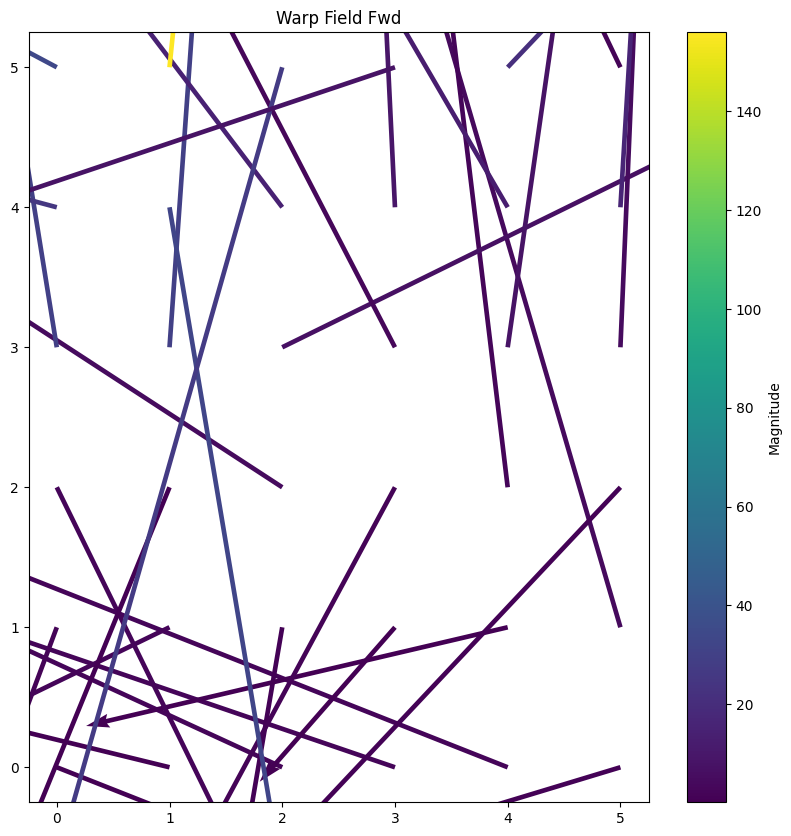

In [35]:
warp_fwd_x = warp_fwd[0, :, :]
warp_fwd_y = warp_fwd[1, :, :]

subsample=200

# Subsample warp_fwd
warp_fwd_x = warp_fwd_x[::subsample, ::subsample]
warp_fwd_y = warp_fwd_y[::subsample, ::subsample]

# Calculate the magnitude of warp_fwd
magnitude_fwd = np.sqrt(warp_fwd_x**2 + warp_fwd_y**2)

# Create a grid of points
y, x = np.mgrid[0:warp_fwd_x.shape[0], 0:warp_fwd_x.shape[1]]

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Display the warp field as a quiver plot
quiver_fwd = ax.quiver(x, y, warp_fwd_x, warp_fwd_y, magnitude_fwd, angles='xy', scale_units='xy', scale=0.1)

# Add a colorbar
fig.colorbar(quiver_fwd, ax=ax, label='Magnitude')

# Set the title
ax.set_title('Warp Field Fwd')

plt.show()

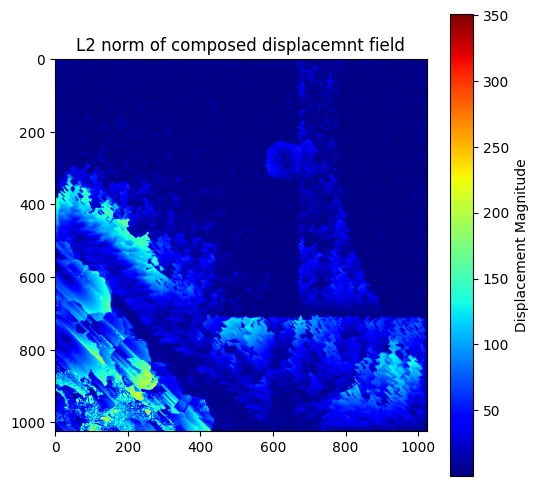

In [19]:
L2_norm_combined_simple = np.sqrt(composed_warp[0]**2 + composed_warp[1]**2)



# Visualize the L2 norm of the combined simple field

plt.figure(figsize=(6, 6))

plt.imshow(L2_norm_combined_simple, cmap='jet')

plt.colorbar(label='Displacement Magnitude')

plt.title("L2 norm of composed displacemnt field")

plt.show()

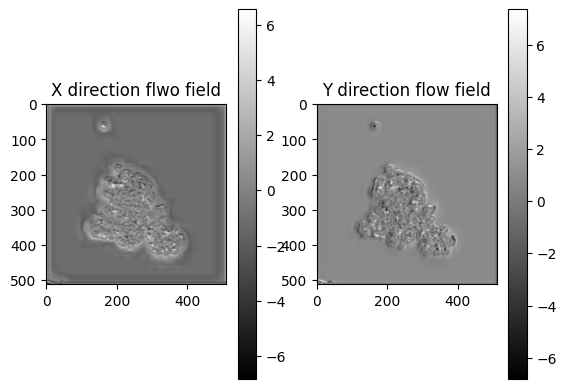

In [7]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(composed_warp[0],cmap='gray')
plt.title('X direction flwo field')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(composed_warp[1],cmap='gray')
plt.title('Y direction flow field')
plt.colorbar()
#Plot colorbar


0.10327644